In [1]:
using BenchmarkTools
using Plots
using DRR

We will need to benchmark four experiments: 

|     | Serial     | Parallel     |
|-----|------------|--------------|
| CPU | CPU Serial | CPU Parallel |
| GPU | GPU Serial | GPU Parallel |

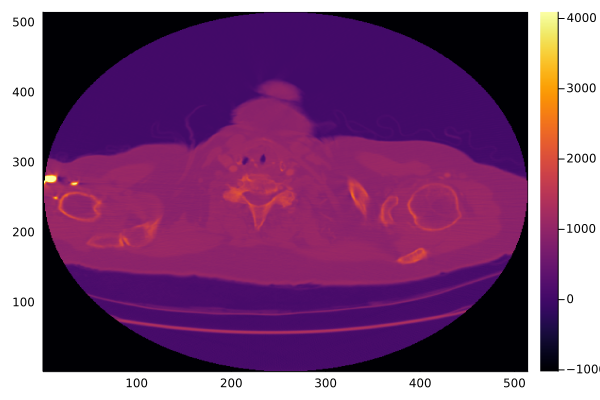

In [2]:
volume, ΔX, ΔY, ΔZ = read_dicom("../data/cxr"; pad=true)
heatmap(volume[:, :, end-1])

In [3]:
# Read the volume
volume, ΔX, ΔY, ΔZ = read_dicom("../data/cxr"; pad=true)
# volume = volume[:, :, 2:end-1]
grid, pixels = volume2grid(volume, ΔX, ΔY, ΔZ)

(GridInterpolations.RectangleGrid{3}([0.0, 0.703125, 1.40625, 2.109375, 2.8125, 3.515625, 4.21875, 4.921875, 5.625, 6.328125  …  354.375, 355.078125, 355.78125, 356.484375, 357.1875, 357.890625, 358.59375, 359.296875, 360.0, 360.703125],[0.0, 0.703125, 1.40625, 2.109375, 2.8125, 3.515625, 4.21875, 4.921875, 5.625, 6.328125  …  354.375, 355.078125, 355.78125, 356.484375, 357.1875, 357.890625, 358.59375, 359.296875, 360.0, 360.703125],[0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5  …  312.5, 315.0, 317.5, 320.0, 322.5, 325.0, 327.5, 330.0, 332.5, 335.0],), Int16[-1024, -1024, -1024, -1024, -1024, -1024, -1024, -1024, -1024, -1024  …  -1024, -1024, -1024, -1024, -1024, -1024, -1024, -1024, -1024, -1024])

In [5]:
# Define the camera
center = Vec3(180., 180., -100)
camera = Camera(center)

# Define the detector plane
center = Vec3(180., 180., 500.)
normal = Vec3(1., -1., -1.)
height, width = 601, 601
Δx, Δy = 2., 2.
detector = Detector(center, normal, height, width, Δx, Δy)

Detector(Vec3{Float64}(180.0, 180.0, 500.0), Vec3{Float64}(1.0, -1.0, -1.0), 601, 601, 2.0, 2.0)

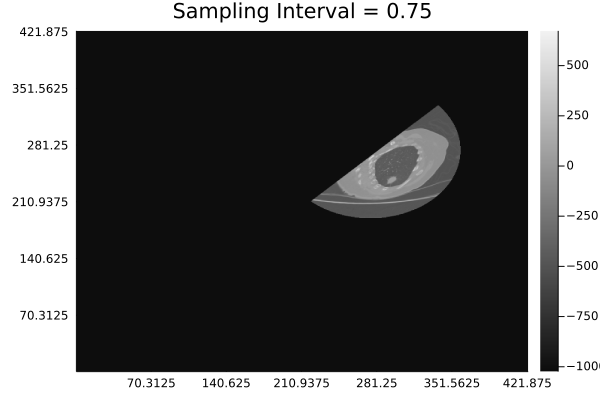

In [19]:
# Generate the DRR
spacing = 0.75
drr = make_drr(grid, pixels, camera, detector, spacing)
heatmap(drr, c=:grays, title=raw"Sampling Interval = " * "$spacing", xformatter = x -> ΔX*x, yformatter = y -> ΔY*y)

In [5]:
rang = vcat(0.005, 0.01:0.01:0.09, 0.1:0.1:0.5, 0.75)

16-element Vector{Float64}:
 0.005
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.2
 0.3
 0.4
 0.5
 0.75

In [34]:
smp = length(rang)

benchtimes = Array{Float64}(undef, smp)

for i = 1:smp
    # Generate the DRR
    spacing = rang[i]
    benchtimes[i] = @elapsed make_drr(grid, pixels, camera, detector, spacing)
end

In [35]:
benchtimes

16-element Vector{Float64}:
 27.4683624
 14.0445356
  7.4280931
  5.125542
  3.9690554
  3.4203947
  2.719457
  2.3534992
  2.3037334
  1.8145279
  1.6868817
  0.9806269
  0.6947561
  0.5577976
  0.5389174
  0.4064301

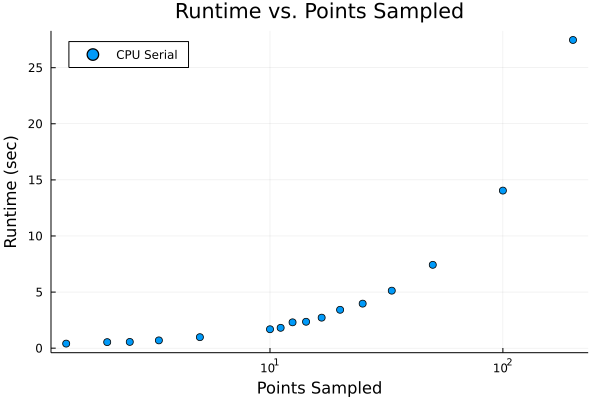

In [49]:
scatter(1 ./ rang, benchtimes, legend=:topleft, xaxis=:log, 
    xlabel="Points Sampled", ylabel="Runtime (sec)", 
    title="Runtime vs. Points Sampled", label="CPU Serial")

In [6]:
using Distributed

In [7]:
# add workers
if nworkers()==1
  addprocs(5)  
  println(workers())
end

[2, 3, 4, 5, 6]


In [8]:
using SharedArrays

In [9]:
@everywhere begin 
    using Pkg; Pkg.activate(".")  # required
    using DRR
    
    function raytrace_trilinear(ray, spacing::Float64, grid, pixels)
        pts = trace.(0:spacing:1; ray=ray)
        interpolations = interpolate.(pts; grid, pixels)
        return sum(interpolations) / length(pts)
    end
    
    function paradrr(projector, spacing, grid, pixels)
        drr = SharedArray{Float64}(length(projector))
        @distributed for i in 1:length(projector)
            ray = projector[i]
            drr[i] = raytrace_trilinear(ray, spacing, grid, pixels)
        end
        return drr
    end
    
end

      From worker 6:	  Activating new project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl\notebooks`
      From worker 3:	  Activating new project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl\notebooks`
      From worker 5:	  Activating new project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl\notebooks`
      From worker 2:	  Activating new project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl\notebooks`
      From worker 4:	  Activating new project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl\notebooks`


  Activating new project at `C:\Users\rubyl\OneDrive\Documents\School\Parallel Computing\FinalProject\DRR.jl\notebooks`


LoadError: On worker 2:
ArgumentError: Package DRR not found in current path:
- Run `import Pkg; Pkg.add("DRR")` to install the DRR package.

Stacktrace:
 [1] [0m[1mrequire[22m
[90m   @ [39m[90m.\[39m[90m[4mloading.jl:967[24m[39m
 [2] top-level scope
[90m   @ [39m[90m[4mIn[9]:3[24m[39m
 [3] [0m[1meval[22m
[90m   @ [39m[90m.\[39m[90m[4mboot.jl:373[24m[39m
 [4] [0m[1m#103[22m
[90m   @ [39m[90mC:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\[39m[90m[4mprocess_messages.jl:274[24m[39m
 [5] [0m[1mrun_work_thunk[22m
[90m   @ [39m[90mC:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\[39m[90m[4mprocess_messages.jl:63[24m[39m
 [6] [0m[1mrun_work_thunk[22m
[90m   @ [39m[90mC:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\[39m[90m[4mprocess_messages.jl:72[24m[39m
 [7] [0m[1m#96[22m
[90m   @ [39m[90m.\[39m[90m[4mtask.jl:423[24m[39m

...and 5 more exceptions.


In [10]:
findz(x, y; a, b, c, d) = (d - a * x - b * y) / c
findz(x::Tuple{Float64,Float64}; a, b, c, d) = findz(x[1], x[2]; a, b, c, d)
append(xy, z) = Vec3(xy..., z)

# Construct the detector array
function make_plane(detector::Detector)
    d = dotprod(detector.center, detector.normal)
    xs = (-detector.height÷2:1:detector.height÷2) * detector.Δx
    ys = (-detector.width÷2:1:detector.width÷2) * detector.Δy
    xys = product(xs, ys) |> collect
    zs = findz.(xys; a=detector.normal.x, b=detector.normal.y, c=detector.normal.z, d=d)
    return append.(xys, zs)
end
get_rays(camera, plane) = [Ray(camera.center, pixel - camera.center) for pixel in plane]

get_rays (generic function with 1 method)

In [11]:
import Base: product
# Set up the detector plane
plane = make_plane(detector)
projector = get_rays(camera, plane);

In [12]:
function make_drr1(projector, spacing, grid, pixels)
    drr = Array{Float64}(undef, length(projector))
    for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, pixels)
    end
    return drr
end

make_drr1 (generic function with 1 method)

In [14]:
function raytrace_trilinear(ray, spacing::Float64, grid, pixels)
    pts = trace.(0:spacing:1; ray=ray)
    interpolations = interpolate.(pts; grid, pixels)
    return sum(interpolations) / length(pts)
end

function paradrr(projector, spacing, grid, pixels)
    drr = SharedArray{Float64}(length(projector))
    @distributed for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, pixels)
    end
    return drr
end

paradrr (generic function with 1 method)

In [15]:
@btime make_drr1(projector, spacing, grid, pixels);

  7.265 s (67817795 allocations: 5.38 GiB)


In [16]:
@btime paradrr(projector, spacing, grid, pixels);

Unhandled Task ERROR: On worker 2:
UndefVarError: #raytrace_trilinear not defined
Stacktrace:
  [1] deserialize_datatype
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:1332
  [2] handle_deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:854
  [3] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:801
  [4] handle_deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:861
  [5] deserialize
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Serialization\src\Serialization.jl:801 [inlined]
  [6] deserialize_global_from_main
    @ C:\Users\rubyl\AppData\Local\Programs\Julia-1.7.1\share\julia\stdlib\v1.7\Distributed\src\clusterserialize.jl:160
  [7] #3
    @ C:\Users\rubyl\Ap

  2.903 s (13558 allocations: 1.01 MiB)
